### Análisis exploratorio del los tiempos de atención en Suscripción y Emisión

Este análisis tiene como objetivo probar si a través de un algoritmo MCMC es posible predecir valores de estos datos. El objetivo es predecir cuándo hay un cambio en el comportamiento de OTs recibidas

In [1]:
# Importing required libraries
import matplotlib
import matplotlib.pyplot as plt # Visualization
import pyodbc # Database connection
import numpy as np# Numerical array operations
import pandas as pd# Data frame manipulation
import seaborn as sns# Visualization settings
sns.set()

A continuación, se ejecuta el _query_ de la base de datos de Procesos, tabla: TB_BI_GrlFactOTSolicitud

In [9]:
# Reading text information from files
server_file = open('server.sql','r')
database_file = open('database.sql', 'r')

In [10]:
# Calling the text file which contains a long query
with open(r'D:\Users\430008252\OneDrive - HDI Seguros\Documentos\EmisionSuscripcion\OTs.sql',encoding='utf-8') as inserts:
    query = inserts.read()
# Settings to connect with the database
server = server_file.readline()
# database = 'Procesos'
database = database_file.readline()
DWH = pyodbc.connect(r'DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';TRUSTED_CONNECTION=TRUE')
# close('database.sql')
# Query from DWH
baseDatos = pd.read_sql_query(query, DWH)

In [11]:
server_file.close()
database_file.close()

In [13]:
baseDatos['TiempoAtencion'] = baseDatos['TiempoEmision']-baseDatos['TiempoAltaOt']# This column contains the elapsed time
baseDatos = baseDatos.drop(columns = ["IdTipoSolicitud","FechaEmision","ComentarioEmision","Coaseguro","EsEmision","IdEstatus","NumerodeCis"])

In [14]:
# Splitting the main data set into three. One per each TipoPuesto
tiempoMaximo =pd.Timedelta("30 days 00:00:00.000")
datosAnalista = baseDatos[(baseDatos['TipoPuesto'] == "Analista") & (baseDatos['TiempoAtencion'] < tiempoMaximo)]
datosESYE = baseDatos[(baseDatos['TipoPuesto'] == "ESYE") & (baseDatos['TiempoAtencion'] < tiempoMaximo)]
datosDAN = baseDatos[(baseDatos['TipoPuesto'] == "DAN") & (baseDatos['TiempoAtencion'] < tiempoMaximo)]

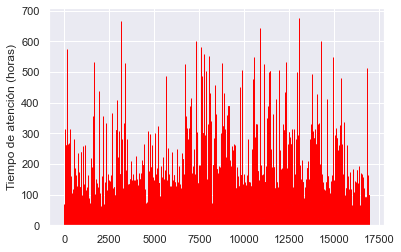

In [15]:
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))
# ax1.set_title("Datos HDI")

f = plt.figure()
ax1 = f.add_subplot(1,1,1)

ax1.bar(np.arange(len(datosAnalista)), datosAnalista.TiempoAtencion.dt.total_seconds()/3600, edgecolor = "red")
ax1.yaxis.set_label_text("Tiempo de atención (horas)")


# ax1.yaxis_date()
plt.show()

In [16]:
datosAnalista.head()

,IdOficina,IdOrigenOT,IdOT,TiempoAltaOt,TiempoActualizacion,TiempoEmision,NombreEstatus,Usuario,PuestoUsuario,TipoPuesto,EstatusOT,IdTipoDocumento,IdPaquete,NumeroDiasMaximo,TAltaVsTActualizacion,TiempoAtencion
0,3,3862,1349204,2020-09-30 14:35:52.023,2020-10-01 02:41:17.050,2020-09-30 19:36:06.570,Suscripción,430005322,SSO,Analista,Cotizacion,23298,NaN,NaN,0.50,0 days 05:00:14.547000
1,3,3862,1350175,2020-10-01 17:52:33.460,2020-10-02 02:20:50.490,2020-10-01 18:24:39.900,Suscripción,430005322,SSO,Analista,Cotizacion,23298,6.0,3.0,0.05,0 days 00:32:06.440000
2,3,3862,1350139,2020-10-01 17:22:10.897,2020-10-02 02:20:50.490,2020-10-01 19:46:13.277,Suscripción,430005322,SSO,Analista,Cotizacion,23298,5.0,3.0,0.24,0 days 02:24:02.380000
3,3,3862,1349891,2020-10-01 13:49:46.050,2020-10-02 02:20:50.490,2020-10-01 18:30:39.380,Suscripción,430005322,SSO,Analista,Cotizacion,23298,7.0,3.0,0.47,0 days 04:40:53.330000
4,3,3862,1349787,2020-10-01 12:39:23.607,2020-10-02 15:00:08.190,2020-10-02 14:13:16.637,Suscripción,430005322,SSO,Analista,Cotizacion,23298,5.0,3.0,1.16,1 days 01:33:53.030000


In [17]:
# datosAnalistaPorFecha = datosAnalista.groupby([datosAnalista["TiempoAltaOt"].dt.date]).mean()
# round(datosAnalista.resample('D',on='TiempoAltaOt').mean().dropna())
datosHDIPorSemana = round(baseDatos.set_index('TiempoAltaOt').groupby(pd.Grouper(freq='W')).count())
datosAnalistaPorSemana = round(datosAnalista.set_index('TiempoAltaOt').groupby(pd.Grouper(freq='W')).count())
datosESYEPorFecha = round(datosESYE.set_index('TiempoAltaOt').groupby(pd.Grouper(freq='W')).count())
datosDANPorSemana = round(datosDAN.set_index('TiempoAltaOt').groupby(pd.Grouper(freq='W')).count())

# Gathering the number of OT per week by atention channel in one single dataframe
ordenesPorSemana = pd.DataFrame({"HDI" : datosHDIPorSemana.IdOficina
                                 , "Analista" : datosAnalistaPorSemana.IdOficina
                                 , "ESYE" : datosESYEPorFecha.IdOficina
                                 , "DAN" : datosDANPorSemana.IdOficina})

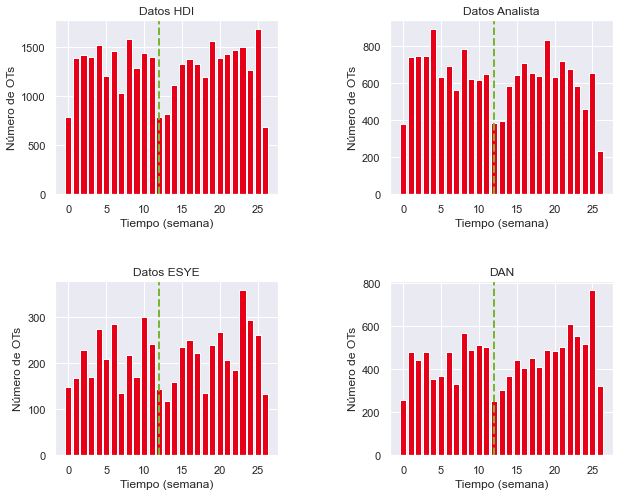

In [18]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))

ax1.set_title("Datos HDI")
ax1.bar(np.arange(len(ordenesPorSemana)),ordenesPorSemana['HDI'], color = "#E60018")
ax1.yaxis.set_label_text("Número de OTs")
ax1.xaxis.set_label_text("Tiempo (semana)")
ax1.axvline(x = 12, color = "#79B530", linestyle = '--', lw = 2)

ax2.set_title("Datos Analista")
ax2.bar(np.arange(len(ordenesPorSemana)),ordenesPorSemana['Analista'], color = "#E60018")
ax2.yaxis.set_label_text("Número de OTs")
ax2.xaxis.set_label_text("Tiempo (semana)")
ax2.axvline(x = 12, color = "#79B530", linestyle = '--', lw = 2)

ax3.set_title("Datos ESYE")
ax3.bar(np.arange(len(ordenesPorSemana)),ordenesPorSemana['ESYE'], color = "#E60018")
ax3.yaxis.set_label_text("Número de OTs")
ax3.xaxis.set_label_text("Tiempo (semana)")
ax3.axvline(x = 12, color = "#79B530", linestyle = '--', lw = 2)

ax4.set_title("DAN")
ax4.bar(np.arange(len(ordenesPorSemana)),ordenesPorSemana['DAN'], color = "#E60018")
ax4.yaxis.set_label_text("Número de OTs")
ax4.xaxis.set_label_text("Tiempo (semana)")
ax4.axvline(x = 12, color = "#79B530", linestyle = '--', lw = 2)

fig.subplots_adjust(hspace = 0.5, wspace=0.5)

### Monte Carlo Markov Chain
A continuación, se procede a modelar la distribución de los datos como variables aleatorias discretas. El objetivo es predecir mediante simulación de Monte Carlo y Cadenas de Markov si hay un momento en el que el número de órdenes recibidas cambia en el tiempo.

In [19]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/(ordenesPorSemana.HDI).mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=len(ordenesPorSemana)-1)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [20]:
with model:
    idx = np.arange(len(ordenesPorSemana))
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [21]:
with model:
    observation = pm.Poisson("obs", lambda_, observed = ordenesPorSemana.HDI)

In [22]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune = 5000, step = step)

<ipython-input-22-8bdaba6d6c03>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune = 5000, step = step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 637 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

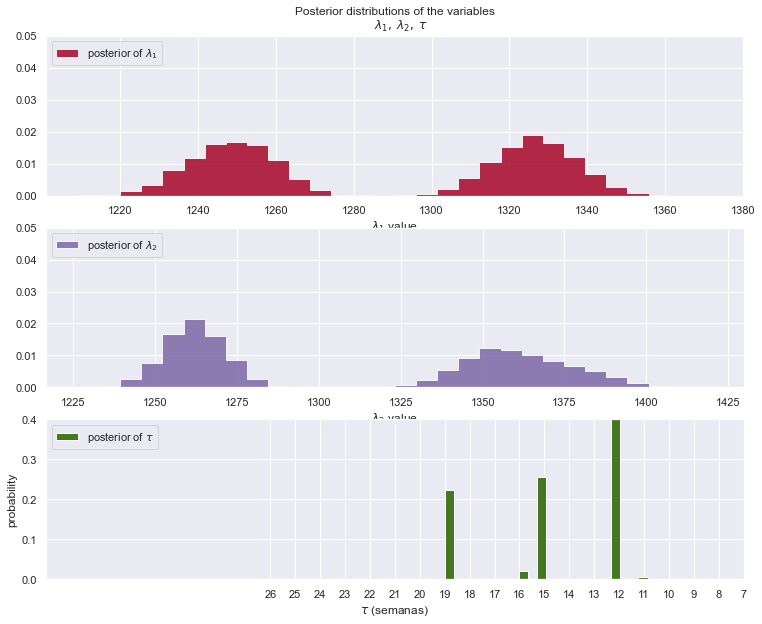

In [24]:
plt.subplots(figsize = (12.5, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
# plt.xlim([15, 30])
plt.ylim([0,0.05])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
# plt.xlim([15, 30])
plt.ylim([0,0.05])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=len(ordenesPorSemana), alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(len(ordenesPorSemana)))

plt.legend(loc="upper left")
plt.ylim([0, .4])
plt.xlim([35, len(ordenesPorSemana)-20])
plt.xlabel(r"$\tau$ (semanas)")
plt.ylabel("probability");

plt.show()

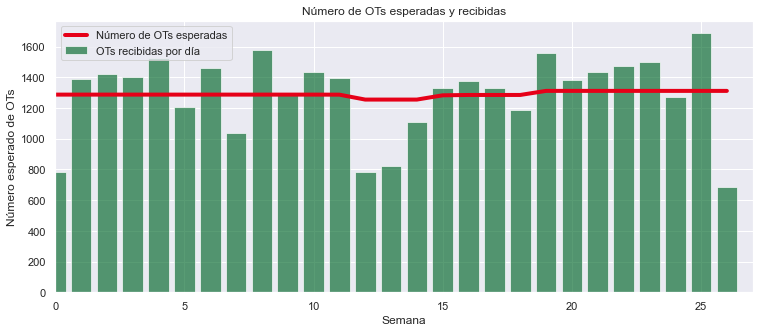

In [25]:
plt.subplots(figsize = (12.5, 5))
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(len(ordenesPorSemana))
for day in range(0, len(ordenesPorSemana)):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(len(ordenesPorSemana)), expected_texts_per_day, lw=4, color="#E60018",
         label="Número de OTs esperadas")
plt.xlim(0, len(ordenesPorSemana))
plt.xlabel("Semana")
plt.ylabel("Número esperado de OTs")
plt.title("Número de OTs esperadas y recibidas")
# plt.ylim(0, 60)
plt.bar(np.arange(len(ordenesPorSemana)), ordenesPorSemana.HDI , color="#006729", alpha=0.65,
        label="OTs recibidas por día")

plt.legend(loc="upper left");

In [26]:
ordenesPorSemana.iloc[12]

HDI         786
Analista    388
ESYE        145
DAN         253
Name: 2020-12-27 00:00:00, dtype: int64

In [27]:
round(ordenesPorSemana.describe())

,HDI,Analista,ESYE,DAN
count,27.0,27.0,27.0,27.0
mean,1291.0,626.0,214.0,451.0
std,262.0,148.0,62.0,112.0
min,689.0,235.0,119.0,253.0
25%,1200.0,585.0,164.0,368.0
50%,1383.0,646.0,218.0,480.0
75%,1448.0,717.0,256.0,502.0
max,1686.0,895.0,360.0,770.0
